In [178]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# 检查GPU是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 读取数据并设置日期索引
df = pd.read_csv('./ETTh1.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 选择特征列和目标列
features = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']
target = 'OT'

# 以 8:2 来分割训练集与测试集
split_ratio = 0.8
split_index = int(len(df) * split_ratio)
train_data = df[:split_index]
test_data = df[split_index:]

# 数据归一化
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# 创建用于模型训练的输入和目标数据
def create_features(data, history_size, target_col_index):
    X, y = [], []
    for i in range(history_size, len(data)):
        X.append(data[i-history_size:i, :-1])  # 所有特征列
        y.append(data[i, target_col_index])  # 目标列
    return np.array(X), np.array(y)

history_size = 48  # 使用过去24个时间点的值预测未来一个时间点

# 获取特征列的索引和目标列的索引
target_col_index = df.columns.get_loc(target)

# 创建训练和测试数据集
X_train, y_train = create_features(train_scaled, history_size, target_col_index)
X_test, y_test = create_features(test_scaled, history_size, target_col_index)

# 转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# 定义批处理大小
batch_size = 64

# 使用 DataLoader 进行批处理
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# 为测试数据也创建 DataLoader
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)



# 验证数据集形状 
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}') # X_train shape: torch.Size([13924, 12, 6]), y_train shape: torch.Size([13924, 1])
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')                           #    [样本数， 时间步， 特征数]
# print(f'Train loader batch example: {next(iter(train_loader))}')



Using device: cuda
X_train shape: torch.Size([13888, 48, 6]), y_train shape: torch.Size([13888, 1])
X_test shape: torch.Size([3436, 48, 6]), y_test shape: torch.Size([3436, 1])


In [179]:
from kan import KAN
import torch.optim as optim

# (batch_size, out_features, in_features)
model = model = KAN([history_size * 6, 1024, 1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
# 检查模型结构
# print(model)

# 获取第一个批次的数据
for X_batch, y_batch in train_loader:

  # 将数据移动到设备 (CPU或GPU)
  X_batch = X_batch.to(device)
  y_batch = y_batch.to(device)

  # 打印输入和输出的形状以及输出值
  print(f"Input X_batch shape: {X_batch.shape}") # torch.Size([32, 12, 6])
  print(f"Input y_batch shape: {y_batch.shape}") # torch.Size([32, 1])

  X_batch = X_batch.view(batch_size, -1)
  print(f"Input X_batch shape: {X_batch.shape}") # torch.Size([32, 12, 6])

  # 前向传播
  output = model(X_batch)

  print(f"Output shape: {output.shape}")         # torch.Size([32, 12, 1])
  # print(f"Output: {output}")

  # 计算损失
  # loss = criterion(output, y_batch)

  # 打印损失
  # print(f"Loss: {loss.item()}")

  break


Input X_batch shape: torch.Size([64, 48, 6])
Input y_batch shape: torch.Size([64, 1])
Input X_batch shape: torch.Size([64, 288])
Output shape: torch.Size([64, 1])


In [180]:
from sklearn.metrics import mean_squared_error


# 训练模型的代码
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        X_batch, y_batch = X_batch, y_batch
        X_batch = X_batch.view(batch_size, -1)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= len(train_loader.dataset)
    if (epoch + 1) % 10 == 0:
        scheduler.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, lr: {scheduler.get_last_lr()[0]:.6f}')



Epoch 1/50, Loss: 0.6209, lr: 0.010000
Epoch 2/50, Loss: 0.0139, lr: 0.010000
Epoch 3/50, Loss: 0.0108, lr: 0.010000
Epoch 4/50, Loss: 0.0095, lr: 0.010000
Epoch 5/50, Loss: 0.0082, lr: 0.010000
Epoch 6/50, Loss: 0.0079, lr: 0.010000
Epoch 7/50, Loss: 0.0078, lr: 0.010000
Epoch 8/50, Loss: 0.0069, lr: 0.010000
Epoch 9/50, Loss: 0.0075, lr: 0.010000
Epoch 10/50, Loss: 0.0088, lr: 0.005000
Epoch 11/50, Loss: 0.0066, lr: 0.005000
Epoch 12/50, Loss: 0.0061, lr: 0.005000
Epoch 13/50, Loss: 0.0060, lr: 0.005000
Epoch 14/50, Loss: 0.0059, lr: 0.005000
Epoch 15/50, Loss: 0.0059, lr: 0.005000
Epoch 16/50, Loss: 0.0061, lr: 0.005000
Epoch 17/50, Loss: 0.0058, lr: 0.005000
Epoch 18/50, Loss: 0.0056, lr: 0.005000
Epoch 19/50, Loss: 0.0055, lr: 0.005000
Epoch 20/50, Loss: 0.0054, lr: 0.002500
Epoch 21/50, Loss: 0.0044, lr: 0.002500
Epoch 22/50, Loss: 0.0041, lr: 0.002500
Epoch 23/50, Loss: 0.0041, lr: 0.002500
Epoch 24/50, Loss: 0.0040, lr: 0.002500
Epoch 25/50, Loss: 0.0042, lr: 0.002500
Epoch 26/

(3436, 1)


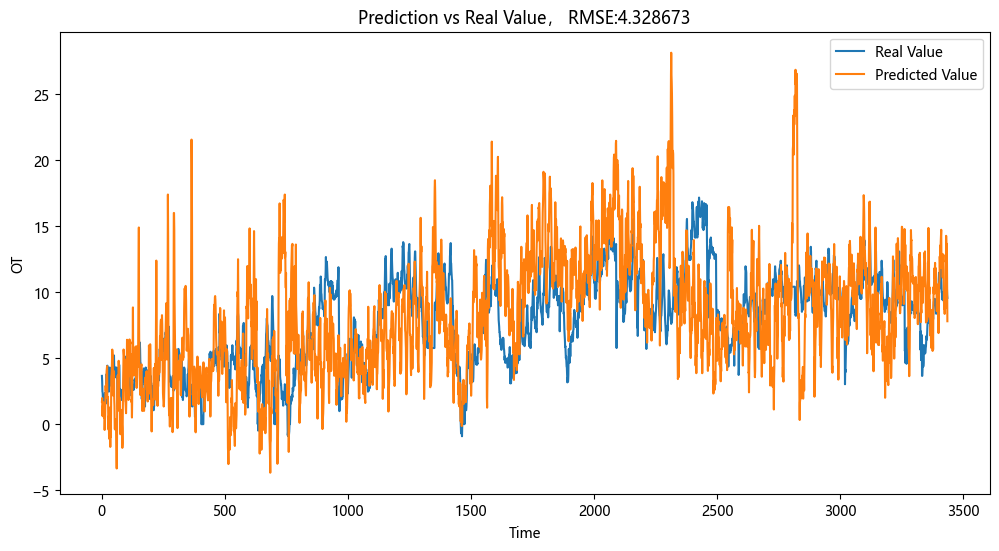

In [186]:
# 使用测试数据进行预测并绘制对比图
model.eval()
with torch.no_grad():
    predictions = model(X_test.view(X_test.size(0), -1)).cpu().numpy()


# 打印预测值维度
print(predictions.shape)
predictions = predictions

# 反归一化预测值和真实值
y_test_unscaled = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), train_scaled.shape[1]-1)), y_test.cpu().numpy()), axis=1))[:, -1]
predictions_unscaled = scaler.inverse_transform(np.concatenate((np.zeros((len(predictions), train_scaled.shape[1]-1)), predictions), axis=1))[:, -1]


# 计算 RMSE
rmse = np.sqrt(mean_squared_error(y_test_unscaled, predictions_unscaled))


# 绘制预测值和真实值的对比图
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='Real Value')
plt.plot(predictions_unscaled, label='Predicted Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('OT')
plt.title(f'Prediction vs Real Value， RMSE:{rmse:2f}')
plt.show()

In [182]:

# # 自定义打印网络结构和层的详细信息
# def print_model_details(model):
#     for name, layer in model.named_children():
#         print(f"{name} : {layer}")
#         if isinstance(layer, nn.ModuleList):
#             for sub_layer in layer:
#                 print(f"  {sub_layer}")
#                 for param_name, param in sub_layer.named_parameters():
#                     print(f"    {param_name}: {param.size()}")

# print_model_details(model)

In [183]:
# import torch
# import matplotlib.pyplot as plt

# def visualize_b_spline_curves(base_weight, spline_weight, spline_scaler, feature_index=0, num_samples=10):
#     # 假设生成 100 个输入值
#     x_values = torch.linspace(0, 1, 100)
    
#     # 创建子图
#     fig, axes = plt.subplots(2, 5, figsize=(20, 10))
#     axes = axes.flatten()
    
#     for sample_index in range(num_samples):
#         # 初始化样条函数值
#         spline_values = torch.zeros_like(x_values)
        
#         # 计算样条函数值
#         for i in range(spline_weight.size(-1)):
#             spline_values += spline_weight[sample_index, feature_index, i] * (x_values ** i)
        
#         # 应用缩放因子
#         spline_values *= spline_scaler[sample_index, feature_index]
        
#         # 应用基函数权重
#         y_values = base_weight[sample_index, feature_index] * spline_values
        
#         # 绘制子图
#         axes[sample_index].plot(x_values.cpu().numpy(), y_values.cpu().numpy(), label=f'Sample {sample_index + 1}')
#         axes[sample_index].set_title(f'Sample {sample_index + 1}')
#         axes[sample_index].set_xlabel('Input')
#         axes[sample_index].set_ylabel('B-spline Value')
#         axes[sample_index].legend()
    
#     plt.tight_layout()
#     plt.show()

# # 假设的模型参数
# base_weight = torch.randn(64, 72)
# spline_weight = torch.randn(64, 72, 8)
# spline_scaler = torch.randn(64, 72)

# # 可视化前 10 个样本的B-样条曲线
# visualize_b_spline_curves(base_weight, spline_weight, spline_scaler, feature_index=0, num_samples=10)


In [184]:
# import torch
# import matplotlib.pyplot as plt

# # 可视化样条曲线的函数
# def visualize_splines(layer, feature_index=0):
#     device = layer.grid.device  # 获取 layer.grid 的设备
#     x_values = torch.linspace(layer.grid.min(), layer.grid.max(), 100).unsqueeze(1).expand(-1, layer.in_features).to(device)  # 将 x_values 移动到同一设备
#     y_values = layer.b_splines(x_values)

#     # 打印 x_values 和 y_values 的形状
#     print(f"x_values shape: {x_values.shape}")
#     print(f"y_values shape: {y_values.shape}")

#     plt.figure(figsize=(10, 6))
#     for i in range(y_values.size(-1)):  # 确保索引不超出范围
#         plt.plot(
#             x_values[:, feature_index].cpu().numpy(),
#             y_values[:, feature_index, i].cpu().numpy(),
#             label=f'Spline {i + 1}'
#         )

#     plt.xlabel('Input')
#     plt.ylabel('B-spline Value')
#     plt.title(f'B-spline Basis Functions for Feature {feature_index}')
#     plt.legend()
#     plt.show()

# # 可视化第一层的样条曲线
# visualize_splines(model.layers[0], feature_index=0)
# visualize_splines(model.layers[1], feature_index=0)

In [185]:
import torch

# 假设你已经定义了一个模型
# model = YourModelClass()

def print_model_total_info(model):
    total_params = 0
    total_memory = 0

    for param in model.parameters():
        param_count = param.numel()
        param_memory = param.element_size() * param_count
        total_params += param_count
        total_memory += param_memory

    total_memory_mb = total_memory / (1024 ** 2)  # 转换为 MB
    print(f"Total number of parameters: {total_params}")
    print(f"Total memory (MB): {total_memory_mb:.2f}")

# 打印整个模型的参数总数和占用的内存
print_model_total_info(model)


Total number of parameters: 2959360
Total memory (MB): 11.29
